In [0]:
import os

In [0]:
!unzip "/content/drive/My Drive/dataset2-master"

In [0]:
from tqdm import tqdm
import cv2
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
def get_data(folder):
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 0
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 2  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 3 
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = cv2.resize(img_file,(80,60))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z

In [0]:
train_folder='/content/dataset2-master/images/TRAIN/'
test_folder='/content/dataset2-master/images/TEST/'
val_folder='/content/dataset2-master/images/TEST_SIMPLE/'

In [0]:
X_train, y_train, z_train=get_data(train_folder)

100%|██████████| 2497/2497 [00:02<00:00, 1183.58it/s]


In [0]:
X_test, y_test, z_test =get_data(test_folder)

100%|██████████| 623/623 [00:00<00:00, 1187.56it/s]


In [0]:
X_train.shape,y_train.shape,z_train.shape

((9957, 60, 80, 3), (9957,), (9957,))

In [0]:
X_val,y_val,z_val=get_data(val_folder)

100%|██████████| 13/13 [00:00<00:00, 926.57it/s]


In [0]:
pd.Series(y_train).value_counts()

0    2499
1    2497
3    2483
2    2478
dtype: int64

In [0]:
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
y_trainHot = to_categorical(y_train, num_classes = 4)
y_testHot = to_categorical(y_test, num_classes = 4)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, MaxPool2D, Input, Softmax, Activation, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import keras
from keras.optimizers import Adam

In [0]:
def keras_model():
    inputs=Input(shape=(60,80,3))
    x = Conv2D(16, 5, strides=(2, 2), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(8, 5, strides=(2, 2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(4, 5, strides=(2, 2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(4, 5, strides=(2, 2), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    y = Dense(4, activation='softmax')(x)
    model=Model(inputs,y)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.01),
                  metrics=['accuracy'])
    return model

In [0]:
model=keras_model()

W0901 13:30:54.546446 139996531279744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0901 13:30:54.574283 139996531279744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0901 13:30:54.579824 139996531279744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0901 13:30:54.608762 139996531279744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0901 13:30:54.610082 1399965312

In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 80, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 40, 16)        1216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 40, 16)        64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 40, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 20, 8)         3208      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 20, 8)         32        
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 20, 8)         0   

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
datagentrain = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.15,
        height_shift_range=0.15,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [0]:
datagentrain.fit(X_train)

In [0]:
import math

In [0]:
checkpoint = ModelCheckpoint('/content/model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [0]:
history = model.fit_generator(datagentrain.flow(X_train, y_trainHot, batch_size=64),
                    steps_per_epoch=math.ceil(X_train.shape[0]/64),
                    epochs=100,
                   validation_data = (X_test,y_testHot),callbacks = callbacks_list)

W0901 13:31:21.944375 139996531279744 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
156/156 [==============================] - 39s 251ms/step - loss: 1.3962 - acc: 0.2613 - val_loss: 12.0740 - val_acc: 0.2509

Epoch 00001: val_acc improved from -inf to 0.25090, saving model to /content/model.hdf5
Epoch 2/100
156/156 [==============================] - 38s 242ms/step - loss: 1.3677 - acc: 0.3027 - val_loss: 12.0999 - val_acc: 0.2493

Epoch 00002: val_acc did not improve from 0.25090
Epoch 3/100
156/156 [==============================] - 38s 243ms/step - loss: 1.3639 - acc: 0.3098 - val_loss: 12.0999 - val_acc: 0.2493

Epoch 00003: val_acc did not improve from 0.25090
Epoch 4/100
156/156 [==============================] - 38s 246ms/step - loss: 1.3411 - acc: 0.3265 - val_loss: 12.0999 - val_acc: 0.2493

Epoch 00004: val_acc did not improve from 0.25090
Epoch 5/100
156/156 [==============================] - 38s 246ms/step - loss: 1.2713 - acc: 0.3758 - val_loss: 12.0999 - val_acc: 0.2493

Epoch 00005: val_acc did not improve from 0.25090
Epoch 6/100
156/156 [=

In [0]:
%matplotlib inline

Text(0.5, 1.0, 'training_loss/epochs')

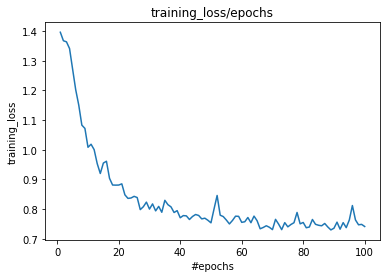

In [0]:
plt.plot(np.arange(1,101,1),history.history['loss'])
plt.xlabel('#epochs')
plt.ylabel('training_loss')
plt.title('training_loss/epochs')

Text(0.5, 1.0, 'training_accuracy/epochs')

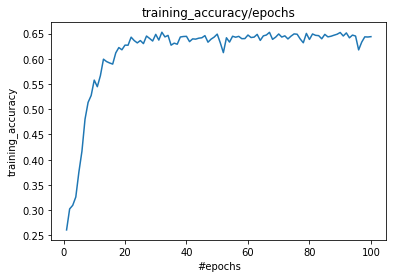

In [0]:
plt.plot(np.arange(1,101,1),history.history['acc'])
plt.xlabel('#epochs')
plt.ylabel('training_accuracy')
plt.title('training_accuracy/epochs')